In [ ]:
# ==========================================================
# Standard library imports
# ==========================================================
import os
import sys
import time

# ==========================================================
# Third-party library imports
# ==========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import RegularGridInterpolator
import random
# ==========================================================
# Local utility imports
# ==========================================================
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Ensure the utilities directory is in the import path
sys.path.insert(0, utilities_dir)
from plotting import *

# Return to the original working directory
os.chdir(current_dir)

# Torch device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) 

import plotting   
import importlib
importlib.reload(plotting)

Using device: cuda


<module 'plotting' from '/home/orincon/Review-Seismic-Waves/main/05_PINNs_helmholz2D/../../utils/plotting.py'>

In [17]:
 

# =====================================================
# 1. Exact solution and RHS
# =====================================================
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)


# =====================================================
# 2. Sine activation + Hard-constrained PINN
# =====================================================
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(Sine())
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        u_hat = self.model(inputs)
        # Hard constraint: 
        return x*(1 - x) *y* (1 - y) * u_hat


# =====================================================
# 3. Sampling points
# =====================================================
def sample_pinn_points(N_int, device="cpu"):
     
    eps = 1e-6

    # Interior points (exclude boundaries)
    x_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)

    return x_int, y_int


# =====================================================
# 4. Loss function (only PDE residual, since BC is hard)
# =====================================================
def pinn_loss(model, x_int, y_int):
    f_pred = model(x_int, y_int)

    # Compute derivatives
    grads = torch.autograd.grad(f_pred, [x_int, y_int],
                                grad_outputs=torch.ones_like(f_pred),
                                create_graph=True)
    f_x, f_y = grads
    f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

    # PDE residual: ∇²f = RHS
    rhs_val = rhs(x_int.detach().cpu().numpy(), y_int.detach().cpu().numpy())
    rhs_torch = torch.tensor(rhs_val, dtype=torch.float32, device=device)

    res = f_xx + f_yy - rhs_torch
    return torch.mean(res**2)


# =====================================================
# 5. Training setup
# =====================================================
N = 100
x_int, y_int = sample_pinn_points(N, device=device)

layers = [2, 275, 275, 1]
model = PINN(layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, x_int, y_int)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}")

# Refinement with L-BFGS
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                    max_iter=5000,
                                    tolerance_grad=1e-8,
                                    tolerance_change=1e-9,
                                    history_size=100,
                                    line_search_fn="strong_wolfe")

lbfgs_iter = 0
def closure():
    global lbfgs_iter
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss(model, x_int, y_int)
    loss.backward()
    if lbfgs_iter % 500 == 0:
        print(f"[L-BFGS] Iteration {lbfgs_iter}: Loss = {loss.item():.4e}")
    lbfgs_iter += 1
    return loss

optimizer_lbfgs.step(closure)

# =====================================================
# 6. Evaluate on grid and compute error
# =====================================================
nx, ny = 60, 60
xg = np.linspace(0, 1, nx)
yg = np.linspace(0, 1, ny)
X, Y = np.meshgrid(xg, yg)
XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                        dtype=torch.float32, device=device)

with torch.no_grad():
    f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)

f_true = f_exact(X, Y)
error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
print(f"Relative L2 error: {error_rel:.4e}")
 

Epoch 0: Loss = 2.9037e+04
Epoch 500: Loss = 2.8001e+04
Epoch 1000: Loss = 1.7733e+04
Epoch 1500: Loss = 6.6823e+03
Epoch 2000: Loss = 3.8019e+03
Epoch 2500: Loss = 2.7631e+03
Epoch 3000: Loss = 2.0510e+03
Epoch 3500: Loss = 1.3819e+03
Epoch 4000: Loss = 8.0198e+02
Epoch 4500: Loss = 4.4674e+02
[L-BFGS] Iteration 0: Loss = 1.9412e+02
[L-BFGS] Iteration 500: Loss = 8.1718e-03
Relative L2 error: 3.8217e-02


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import pandas as pd
import os
import random

# =====================================================
# 0. Fix reproducibility
# =====================================================
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# =====================================================
# 1. Exact solution and RHS
# =====================================================
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# =====================================================
# 2. Sine activation + Hard-constrained PINN
# =====================================================
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layer_list.append(Sine())
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        u_hat = self.model(inputs)
        return x * (1 - x) * y * (1 - y) * u_hat

# =====================================================
# 3. Sampling points
# =====================================================
def sample_pinn_points(N_int, device="cpu"):
    eps = 1e-6
    x_int = eps + (1 - 2 * eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2 * eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)
    return x_int, y_int

# =====================================================
# 4. Loss function
# =====================================================
def pinn_loss(model, x_int, y_int, device):
    f_pred = model(x_int, y_int)
    grads = torch.autograd.grad(f_pred, [x_int, y_int],
                                grad_outputs=torch.ones_like(f_pred),
                                create_graph=True)
    f_x, f_y = grads
    f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

    rhs_val = rhs(x_int.detach().cpu().numpy(), y_int.detach().cpu().numpy())
    rhs_torch = torch.tensor(rhs_val, dtype=torch.float32, device=device)

    res = f_xx + f_yy - rhs_torch
    return torch.mean(res ** 2)

# =====================================================
# 5. Training + evaluation loop
# =====================================================
def run_pinn_experiments(device="cpu", num_repeats=3, save_results=True):
    N_values = [100, 400, 900]  # Fewer for quick test — adjust later
    layers = [2, 275, 275, 1]
    results = []
    os.makedirs("models", exist_ok=True)

    for N in N_values:
        print(f"\n=== Testing with {N} training points ===")
        train_times, eval_times, rel_errors = [], [], []

        for run in range(num_repeats):
            print(f"\n   Run {run + 1}/{num_repeats}")
            # --- Control reproducibility per run
            set_seed(42 + run)

            # Sample points
            x_int, y_int = sample_pinn_points(N, device=device)

            # Model setup
            model = PINN(layers).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            # ================================
            #  Training with Adam (log loss)
            # ================================
            print(f"\n--- Training (Adam) for N={N}, Run={run + 1} ---")
            t0 = time.time()
            for epoch in range(3000):
                optimizer.zero_grad()
                loss = pinn_loss(model, x_int, y_int, device)
                loss.backward()
                optimizer.step()

                # Print every 500 epochs
                if epoch % 500 == 0 or epoch == 2999:
                    print(f"Epoch {epoch:4d} | Loss = {loss.item():.6e}")
            t_adam = time.time() - t0

            # ================================
            #  Refine with L-BFGS
            # ================================
            optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                                max_iter=2000,
                                                tolerance_grad=1e-8,
                                                tolerance_change=1e-9,
                                                history_size=100,
                                                line_search_fn="strong_wolfe")

            def closure():
                optimizer_lbfgs.zero_grad()
                loss = pinn_loss(model, x_int, y_int, device)
                loss.backward()
                return loss

            t_lbfgs_start = time.time()
            optimizer_lbfgs.step(closure)
            t_train_total = t_adam + (time.time() - t_lbfgs_start)
            train_times.append(t_train_total)

            # ================================
            #  Evaluation
            # ================================
            nx, ny = 100, 100
            xg = np.linspace(0, 1, nx)
            yg = np.linspace(0, 1, ny)
            X, Y = np.meshgrid(xg, yg)
            XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                                    dtype=torch.float32, device=device)

            t_eval_start = time.time()
            with torch.no_grad():
                f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)
            t_eval = time.time() - t_eval_start
            eval_times.append(t_eval)

            f_true = f_exact(X, Y)
            error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
            rel_errors.append(error_rel)

            print(f"      Run {run + 1}: Error = {error_rel:.3e}, Train = {t_train_total:.2f}s, Eval = {t_eval:.3f}s")

            # Save this run’s model
            model_name = f"N_{N}_run{run + 1}.pt"
            model_path = os.path.join("models", model_name)
            torch.save(model.state_dict(), model_path)

        # ================================
        # Aggregate statistics
        # ================================
        mean_err, std_err = np.mean(rel_errors), np.std(rel_errors)
        mean_train, std_train = np.mean(train_times), np.std(train_times)
        mean_eval, std_eval = np.mean(eval_times), np.std(eval_times)
        best_idx = int(np.argmin(rel_errors))
        best_error = rel_errors[best_idx]

        # Save best model
        best_model_name = f"N_{N}_best.pt"
        best_model_path = os.path.join("models", best_model_name)
        best_run_path = os.path.join("models", f"N_{N}_run{best_idx + 1}.pt")
        best_model_state = torch.load(best_run_path)
        torch.save(best_model_state, best_model_path)
        print(f"   >> Best model saved: {best_model_path}")

        result = {
            "N_points": N,
            "mean_rel_error": mean_err,
            "std_rel_error": std_err,
            "best_rel_error": best_error,
            "mean_train_time_s": mean_train,
            "std_train_time_s": std_train,
            "mean_eval_time_s": mean_eval,
            "std_eval_time_s": std_eval
        }
        results.append(result)

        print(f"   >> Avg Rel Error: {mean_err:.3e} ± {std_err:.1e}")
        print(f"   >> Avg Train Time: {mean_train:.2f} ± {std_train:.2f}s")
        print(f"   >> Avg Eval Time: {mean_eval:.3f} ± {std_eval:.3f}s")

    # ================================
    # Save results summary
    # ================================
    if save_results:
        os.makedirs("data", exist_ok=True)
        df = pd.DataFrame(results)
        df.to_csv("data/pinn_helmholtz_experiment.csv", index=False)
        print("\nResults saved to data/pinn_helmholtz_experiment.csv")

    return results

# =====================================================
# 6. Run experiments
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = run_pinn_experiments(device=device, num_repeats=3)



=== Testing with 100 training points ===

   Run 1/3

--- Training (Adam) for N=100, Run=1 ---
Epoch    0 | Loss = 2.280414e+04
Epoch  500 | Loss = 2.172969e+04
Epoch 1000 | Loss = 1.280088e+04
Epoch 1500 | Loss = 4.126282e+03
Epoch 2000 | Loss = 2.345225e+03
Epoch 2500 | Loss = 1.487769e+03
Epoch 2999 | Loss = 1.029939e+03


KeyboardInterrupt: 

Relative L2 error: 3.8217e-02


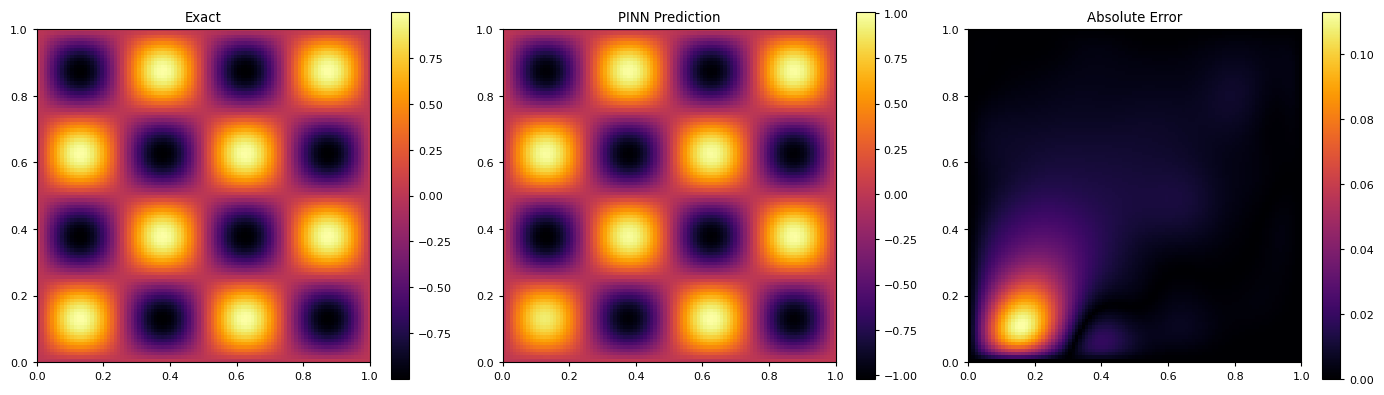

In [20]:
# =====================================================
# 6. Evaluate on grid and compute error
# =====================================================
nx, ny = 100, 100
xg = np.linspace(0, 1, nx)
yg = np.linspace(0, 1, ny)
X, Y = np.meshgrid(xg, yg)
XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                        dtype=torch.float32, device=device)

with torch.no_grad():
    f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)

f_true = f_exact(X, Y)
error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
print(f"Relative L2 error: {error_rel:.4e}")

# =====================================================
# 7. Plot
# =====================================================
fig, axs = plt.subplots(1, 3, figsize=(14,4))
im0 = axs[0].imshow(f_true, extent=[0,1,0,1], origin='lower', cmap='inferno')
axs[0].set_title("Exact")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(f_pred, extent=[0,1,0,1], origin='lower', cmap='inferno')
axs[1].set_title("PINN Prediction")
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(np.abs(f_pred - f_true), extent=[0,1,0,1], origin='lower', cmap='inferno')
axs[2].set_title("Absolute Error")
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

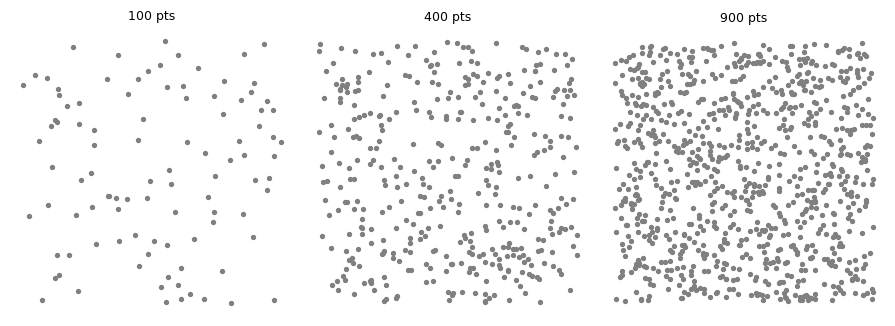

In [23]:
import torch
import matplotlib.pyplot as plt

# ==========================================================
# Función para muestrear puntos interiores aleatorios
# ==========================================================
def sample_pinn_points(N, device="cpu"):
    eps = 1e-6
    # N: número de puntos por eje → total N² puntos
    N_total = N * N
    x =  torch.rand((N_total, 1), device=device)
    y =  torch.rand((N_total, 1), device=device)
    return x, y

# ==========================================================
# Configuración de mallas y figura
# ==========================================================
device = "cpu"
N_values = [10, 20, 30]

fig, axes = plt.subplots(1, 3, figsize=(9, 3.2))

for ax, N in zip(axes, N_values):
    x, y = sample_pinn_points(N, device=device)
    ax.scatter(x.cpu(), y.cpu(), s=8, color='gray')
    ax.set_title(f"{N*N} pts", fontsize=9)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

plt.tight_layout()
plt.show()
